In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

import ipynbname
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [3]:
# Timing utilities
start_time = None

def start_timer():
    global start_time
    torch.cuda.synchronize()
    start_time = time.time()

def end_timer_and_print():
    torch.cuda.synchronize()
    end_time = time.time()
    print("\nTotal execution time {:.3f} sec".format(end_time - start_time))

## Loading Data

In [5]:
data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

In [11]:
class_inds = [7, 1, 4] Distinguishing examples while building concepts in hippocampal and artificial networks
num_classes = len(class_inds)
class_size = 256

inds_by_class = [torch.where(data.targets == class_idx)[0][:class_size] 
                       for class_idx in class_inds]

data_inds = torch.flatten(torch.stack(inds_by_class).T)

In [12]:
batch_size = 64

dataloader = DataLoader(Subset(data, data_inds),
                        batch_size=batch_size, shuffle=True)

print("Number of batches: ", len(dataloader))

for X, y in dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Number of batches:  12
Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


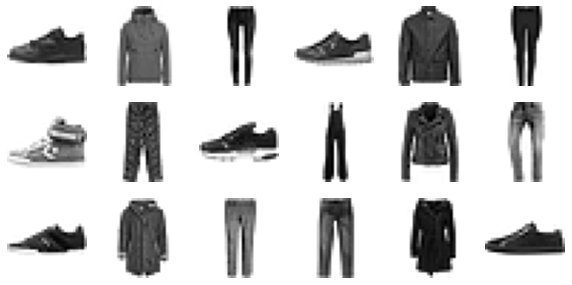

In [13]:
plt.figure(figsize=(10, 5))
X_samples = next(iter(dataloader))[0]
for i, img in enumerate(X_samples):
    if i >= 3*6: break
    plt.subplot(3, 6, i+1)
    plt.imshow(img[0], cmap='gray_r')
    plt.axis('off')

## Network Architecture

In [63]:
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        #return torch.sign(input)
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return F.hardtanh(grad_output)

class StraightThroughEstimator(nn.Module):
    def __init__(self):
        super(StraightThroughEstimator, self).__init__()

    def forward(self, x):
        return STEFunction.apply(x)

In [64]:
class LinearAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            #nn.Linear(28*28, 1024),
            #nn.BatchNorm1d(1024),
            nn.Linear(28*28, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 1024),
            nn.BatchNorm1d(1024),
            StraightThroughEstimator()
        )
        self.decoder = nn.Sequential(
            #nn.Linear(1024, 28*28),
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        self.unflatten = nn.Unflatten(-1, (1, 28, 28))
        
    def forward(self, x):
        input_shape = x.shape
        x = self.flatten(x)
        features = self.encoder(x)
        x = self.decoder(features)
        x = self.unflatten(x)
        return x, features

In [65]:
class SparseMSELoss(nn.Module):
    def __init__(self, sp, sp_strength):
        super().__init__()
        self.sp = sp
        self.sp_strength = sp_strength

    def forward(self, pred, x, features):
        mse_loss = torch.mean((pred - x)**2)
        
        sp_hat = features.mean(1)
        kl_divergence = -self.sp * torch.log(sp_hat) - (1-self.sp) * torch.log(1-sp_hat)
        sp_loss = kl_divergence.mean()
        
        return mse_loss + self.sp_strength * sp_loss

class SparseLoss(nn.Module):
    def __init__(self, sp):
        super().__init__()
        self.sp = sp

    def forward(self, features):
        sp_hat = features.mean(1)
        kl_divergence = -self.sp * torch.log(sp_hat) - (1-self.sp) * torch.log(1-sp_hat)
        return kl_divergence.mean()

## Initializing and training

In [66]:
def train(dataloader, model,
          err_criterion, sparse_criterion, sparse_strength,
          optimizer, num_epochs):
    size = len(dataloader.dataset)
    model.train()
    
    mean_err = 0
    mean_sparse_loss = 0
    mean_sp = 0
    
    X_list = []
    pred_list = []
    
    for t in range(num_epochs):
        for batch, (X, _) in enumerate(dataloader):
            X = X.to(device)
            pred, features = model(X)
            
            err = err_criterion(pred, X)
            sparse_loss = sparse_criterion(features)
            mean_err += err.item() * len(X)
            mean_sparse_loss += sparse_loss.item() * len(X)
            mean_sp += features.detach().mean().item() * len(X)

            loss = err + sparse_strength * sparse_loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        mean_err = (mean_err / size)**0.5
        mean_sparse_loss /= size
        mean_sp /= size
        print(f"Epoch {t:>3d}   ", end='')
        print(f"RMSE: {mean_err:>6f}, sloss: {mean_sparse_loss:>6f}, sparsity: {mean_sp:>6f}")
        
        X_list.append(X.detach())
        pred_list.append(pred.detach())
        
    return X_list, pred_list

In [67]:
model = LinearAE().to(device)
print(model)

sp = 0.1
# For features with states -1 and +1 instead of 0 and 1
#sp = 2 * sp - 1
err_criterion = nn.MSELoss(reduction='mean')
sparse_criterion = SparseLoss(sp)
sparse_strength = 10

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

LinearAE(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): StraightThroughEstimator()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1024, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=784, bias=True)
    (4): Sigmoid()
  )
  (unflatten): Unflatten(dim=-1, unflattened_size=(1, 28, 28))
)


In [68]:
num_epochs = 150
start_timer()
train_X, train_pred = train(dataloader, model,
                            err_criterion, sparse_criterion, sparse_strength,
                            optimizer, num_epochs)
end_timer_and_print()
print("Done!")

Epoch   0   RMSE: 0.378024, sloss: 0.691337, sparsity: 0.498294
Epoch   1   RMSE: 0.277222, sloss: 0.688759, sparsity: 0.497177
Epoch   2   RMSE: 0.219621, sloss: 0.684042, sparsity: 0.494234
Epoch   3   RMSE: 0.192127, sloss: 0.678531, sparsity: 0.490738
Epoch   4   RMSE: 0.178771, sloss: 0.671437, sparsity: 0.486172
Epoch   5   RMSE: 0.168902, sloss: 0.666013, sparsity: 0.482651
Epoch   6   RMSE: 0.163125, sloss: 0.659303, sparsity: 0.478243
Epoch   7   RMSE: 0.156396, sloss: 0.653136, sparsity: 0.474147
Epoch   8   RMSE: 0.151627, sloss: 0.646691, sparsity: 0.469819
Epoch   9   RMSE: 0.150402, sloss: 0.639336, sparsity: 0.464830
Epoch  10   RMSE: 0.145358, sloss: 0.633765, sparsity: 0.461011
Epoch  11   RMSE: 0.143537, sloss: 0.627939, sparsity: 0.456975
Epoch  12   RMSE: 0.140263, sloss: 0.621931, sparsity: 0.452791
Epoch  13   RMSE: 0.138034, sloss: 0.616346, sparsity: 0.448834
Epoch  14   RMSE: 0.135798, sloss: 0.611436, sparsity: 0.445330
Epoch  15   RMSE: 0.135144, sloss: 0.605

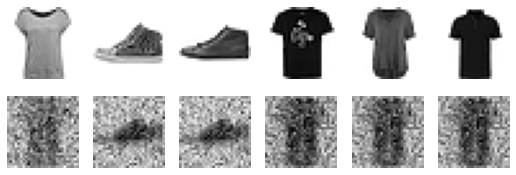

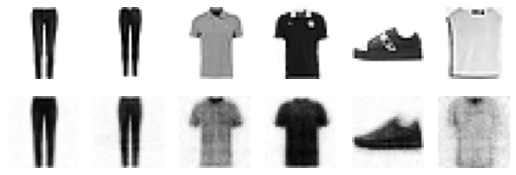

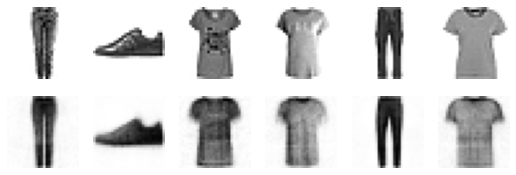

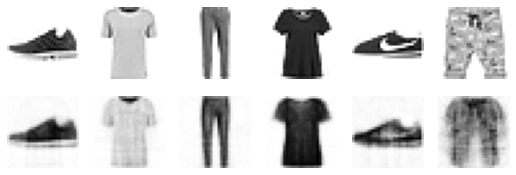

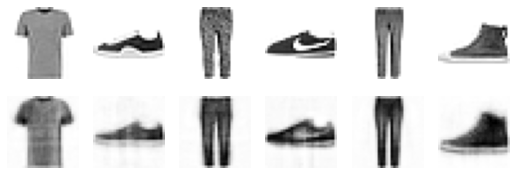

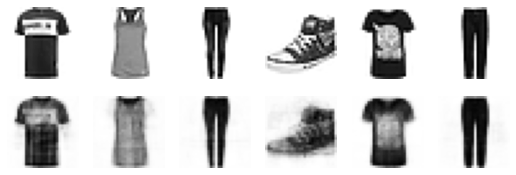

In [69]:
for t in list(range(0, num_epochs, 30)) + [num_epochs-1]:
    plt.figure(figsize=(9, 3))
    imgs = train_X[t].cpu().numpy()
    recons = train_pred[t].cpu().numpy()
    for i, img in enumerate(imgs):
        if i >= 6: break
        plt.subplot(2, 6, i+1)
        plt.imshow(img[0], cmap='gray_r')
        plt.axis('off')
        
    for i, img in enumerate(recons):
        if i >= 6: break
        plt.subplot(2, 6, 6+i+1)
        plt.imshow(img[0], cmap='gray_r')
        plt.axis('off')

## Obtaining test results

In [70]:
def test(dataloader, model, err_criterion):
    size = len(dataloader.dataset)
    model.eval()
    
    mean_err = 0
    mean_sp = 0
    
    X_list = []
    y_list = []
    pred_list = []
    features_list = []
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred, features = model(X)
            
            err = err_criterion(pred, X)
            mean_err += err.item() * len(X)
            mean_sp += features.detach().mean().item() * len(X)
            
            X_list.append(X.detach())
            y_list.append(y.detach())
            pred_list.append(pred.detach())
            features_list.append(features.detach())
            
    mean_err = (mean_err / size)**0.5
    mean_sp /= size
    print(f"RMSE: {mean_err:>6f}, sparsity: {mean_sp:>6f}")
    
    return torch.cat(X_list), torch.cat(y_list), torch.cat(pred_list), torch.cat(features_list)

In [71]:
test_X, test_y, test_pred, test_features = test(dataloader, model, err_criterion)

RMSE: 0.084694, sparsity: 0.093555


In [72]:
test_inds_by_class = [torch.where(test_y == class_idx)[0] for class_idx in class_inds]

X_by_class = [test_X.index_select(0, inds) for inds in test_inds_by_class]
pred_by_class = [test_pred.index_select(0, inds) for inds in test_inds_by_class]
features_by_class = [test_features.index_select(0, inds) for inds in test_inds_by_class]

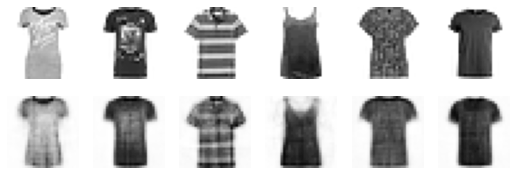

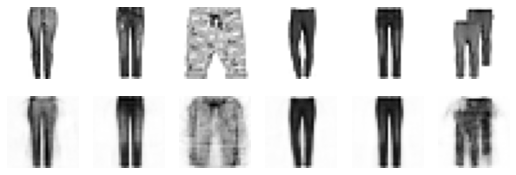

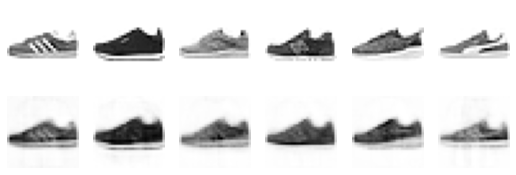

In [73]:
for X, pred in zip(X_by_class, pred_by_class):
    plt.figure(figsize=(9, 3))
    imgs = X.cpu().numpy()
    recons = pred.cpu().numpy()
    for i, img in enumerate(imgs):
        if i >= 6: break
        plt.subplot(2, 6, i+1)
        plt.imshow(img[0], cmap='gray_r')
        plt.axis('off')
        
    for i, img in enumerate(recons):
        if i >= 6: break
        plt.subplot(2, 6, 6+i+1)
        plt.imshow(img[0], cmap='gray_r')
        plt.axis('off')

## Calculating correlation

In [74]:
def pearson_correlation(x, y):
    if x.shape != y.shape:
        raise Exception("Arguments must have same shape")
    x_centered = x - x.mean(-1, keepdim=True)
    y_centered = y - y.mean(-1, keepdim=True)
    
    return ( torch.sum(x_centered * y_centered, -1)
             * torch.rsqrt(torch.sum(x_centered**2, -1) * torch.sum(y_centered**2, -1)) )

def pairwise_correlation(tensor_of_vectors):
    if tensor_of_vectors.dim() != 2:
        raise Exception("Argument must be a 2D tensor")
    inds_of_pairs = torch.combinations(torch.arange(tensor_of_vectors.shape[0])).T
    inds_of_pairs = inds_of_pairs.to(device)
    first_vectors = tensor_of_vectors.index_select(0, inds_of_pairs[0])
    second_vectors = tensor_of_vectors.index_select(0, inds_of_pairs[1])
    
    correlations = pearson_correlation(first_vectors, second_vectors)
    return correlations.mean()

In [75]:
print("Correlations by class:")
print([pairwise_correlation(features).item() for features in features_by_class])

Correlations by class:
[0.1176111176609993, 0.11730506271123886, 0.21472689509391785]


## Exporting model and results

In [76]:
nb_name = ipynbname.name()

In [77]:
torch.save({
    'model_state_dict': model.state_dict(),
    #'dataloader': dataloader,
    'class_inds': class_inds,
    'X_by_class': X_by_class,
    'pred_by_class': pred_by_class,
    'features_by_class': features_by_class
}, f"results/{nb_name}_model.pt")

In [78]:
h5file = h5py.File(f'results/{nb_name}_features.h5', 'w')

In [79]:
for i, features in enumerate(features_by_class):
    h5name = f"class_{i}"
    h5data = features.cpu().numpy().astype(np.int8)
    h5dataset = h5file.create_dataset(h5name, data=h5data, compression='gzip')
    print(h5dataset)

<HDF5 dataset "class_0": shape (256, 1024), type "|i1">
<HDF5 dataset "class_1": shape (256, 1024), type "|i1">
<HDF5 dataset "class_2": shape (256, 1024), type "|i1">


In [80]:
h5file.close()

## Analyzing concepts

In [81]:
X_concepts = [X.mean(0) for X in X_by_class]
X_shape = X_concepts[0].shape
pred_concepts = [pred.mean(0) for pred in pred_by_class]

In [82]:
def sparse_binarize(vector, sp):
    return (vector >= vector.quantile(1-sp)).float()

features_means = [sparse_binarize(features.mean(0), sp) for features in features_by_class]

model.eval()
with torch.no_grad():
    features_concepts = [model.unflatten(model.decoder(features.unsqueeze(0))).squeeze(0)
                         for features in features_means]

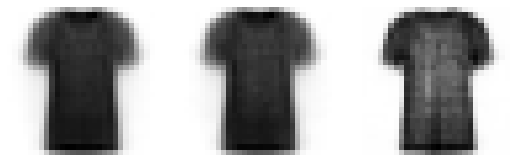

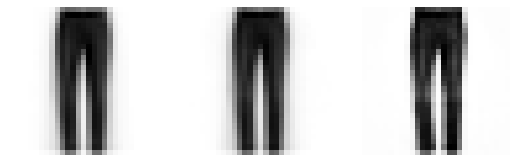

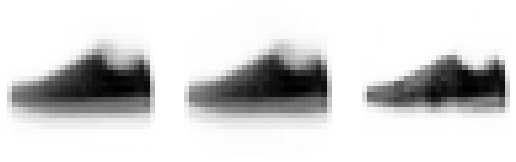

In [83]:
for X, pred, features in zip(X_concepts, pred_concepts, features_concepts):
    plt.figure(figsize=(9, 3))
    img = X.cpu().numpy()
    recon = pred.cpu().numpy()
    assimilation = features.cpu().numpy()
    plt.subplot(1, 3, 1)
    plt.imshow(img[0], cmap='gray_r')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(recon[0], cmap='gray_r')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(assimilation[0], cmap='gray_r')
    plt.axis('off')